<center style="font-size:30px"> sktime: A Unified Framework for ML with Time Series</center>
<br>

<center style="font-size:20px">Berlin Time Series Analysis Meetup, 8 September 2020</center>
<br>

<center style="font-size:20px"> Markus Löning (GitHub: @mloning)
<br>
<br>
    
<table>
    <tr><td>
    <img src="images/sktime-logo.jpg" width=120 height=120 />
    </td><td>
    <img src="images/the-alan-turing-institute.png" width=240/>
    </td></tr>
</table>

<br>

## About me

<table>
    <tr><td>
    <img src="https://www.hamburg.de/image/1157354/4x3/750/563/7873493a3e8c3e58ff1f2e7711b0c86d/JL/michel-02.jpg" width=300 />
    </td><td>
    <img src="https://upload.wikimedia.org/wikipedia/commons/f/f4/Brixton_high_street.jpg" width=400 />
    </td><td>
    <img src="https://www.travel-in-portugal.com/sites/default/files/praia-armacao-pera.jpg" width=400 />
    </td></tr>
</table>

## Towards a more unified & interoperable time series ecosystem

* large and diverse research field
* various different but related learning tasks - hard to distinguish
* many small packages, often not well integrated with other ML toolboxes and hard to inter-operate
* methodology experts are often not well connected with domain experts who work with time series data

Our goal is to make the time series analysis landscape more **understandable, usable and interoperable** by creating a **unified framework** based on a clear taxonomy of learning tasks and modelling approaches. 

## Let's get started with an example

There are a wide variety of problem that can be formulated as time series classification problems. In this notebook, we use the [arrow head problem](https://timeseriesclassification.com/description.php?Dataset=ArrowHead).

The arrowhead data consists of outlines of the images of arrow heads. The classification of projectile points is an important topic in anthropology. The classes are based on shape distinctions such as the presence and location of a notch in the arrow.

The shapes of the projectile points are converted into a sequence using the angle-based method as described in this [blog post](https://izbicki.me/blog/converting-images-into-time-series-for-data-mining.html).

<table>
    <tr><td>
    <img src="https://timeseriesclassification.com/images/datasets/Arrowhead.png" width=200/>
    </td><td>
    <img src="https://izbicki.me/img/uploads/2011/10/human-skull.png" width=400/>
    </td></tr>
</table>



In [1]:
from sktime.datasets import load_italy_power_demand as load_arrow_head
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X, y = load_arrow_head(return_X_y=True)
X.head()

,dim_0
0,0 -0.710520 1 -1.183300 2 -1.372400 3...
1,0 -0.993010 1 -1.426800 2 -1.579900 3...
2,0 1.319100 1 0.569770 2 0.195130 3...
3,0 -0.812440 1 -1.157600 2 -1.416400 3...
4,0 -0.972840 1 -1.390500 2 -1.536700 3...


We have univariate time series data, represented in a `pandas.DataFrame` with a single column.

If we represent it in a `numpy.array`, our feature matrix `X` has 500 columns - however, they are not 500 separate features, but a time series with 500 observations ordered in time!

In [3]:
from sktime.utils.data_container import nested_to_3d_numpy
X_np = nested_to_3d_numpy(X)
print(X_np.shape)

(1096, 1, 24)


Each series has been labelled with one of three class labels.

In [4]:
labels, counts = np.unique(y, return_counts=True)
print(labels, counts)

['1' '2'] [547 549]


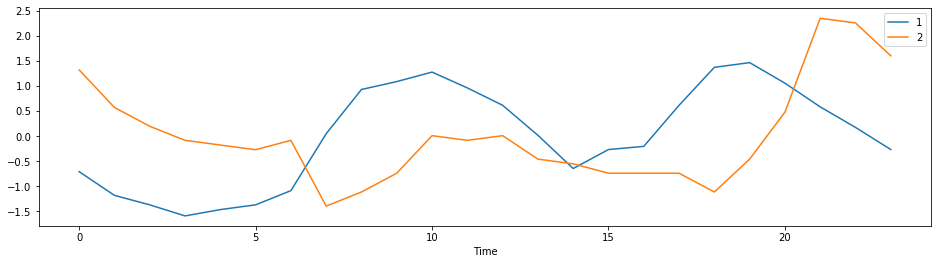

In [5]:
def select_series(X, y, label): return X.iloc[np.where(y == label)[0][0], :].iloc[0]

fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
for label in labels:
    ax.plot(select_series(X, y, label), label=label)
ax.set(xlabel="Time")
ax.legend();

## Time series classification

1. **Generative setting.** *Multiple independent* instances of time series of the *same kind of measurement* together with associated class labels (panel data)
2. **Learning.** Learn association between time series and class label from set of training instances which is generalizable to new instances (similar to tabular classification with the only difference that features are now entire time series and not just primitive values)
3. **Evaluation.** Estimate and compare generalization error on unseen test instances

<img src="images/time-series-classification.png" width=500/>

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(822, 1) (822,) (274, 1) (274,)


### Why not use scikit-learn? 
1. Time binning treating each time points as a separate feature, ignoring any information in the order of observations
2. Feature extraction 


#### Treating time points as separate features (tabularisation)
Alternatively, we could bin and aggregate observations in time bins of different length.

In [7]:
from sktime.utils.data_container import tabularize
from sklearn.ensemble import RandomForestClassifier

X_train_tab = tabularize(X_train)
X_test_tab = tabularize(X_test)

X_train_tab.head()

,dim_0__0,dim_0__1,dim_0__2,dim_0__3,dim_0__4,dim_0__5,dim_0__6,dim_0__7,dim_0__8,dim_0__9,...,dim_0__14,dim_0__15,dim_0__16,dim_0__17,dim_0__18,dim_0__19,dim_0__20,dim_0__21,dim_0__22,dim_0__23
38,-0.82049,-1.1717,-1.4958,-1.6038,-1.6579,-1.5498,-1.1717,-0.73946,0.58414,1.15140,...,0.69219,0.80024,0.88127,0.47609,0.36804,0.61115,0.36804,0.746210,0.151940,-0.36129
427,-1.02070,-1.2982,-1.4765,-1.5756,-1.5756,-1.4567,-1.2387,-0.26756,0.38647,0.74322,...,0.50539,0.68376,0.92159,1.27830,1.10000,0.98105,0.52521,0.208100,-0.227920,-0.44593
145,-0.92842,-1.3455,-1.4772,-1.7187,-1.7187,-1.3455,-1.1260,0.01555,0.67414,1.26690,...,0.38875,0.45461,0.45461,0.38875,0.73999,1.22300,0.71804,0.410700,-0.160070,-0.46741
649,-0.97818,-1.3300,-1.4942,-1.6114,-1.6583,-1.4003,-1.0016,-0.29805,0.71043,0.99187,...,0.26482,0.40554,0.42899,0.49935,1.32020,1.53130,0.89805,0.382090,-0.040066,-0.48567
775,-0.84849,-1.3591,-1.5225,-1.5225,-1.5225,-1.5225,-1.1957,-0.27659,0.64254,1.23490,...,0.51999,0.56084,0.56084,0.56084,1.09190,1.07150,0.56084,0.091061,-0.256160,-0.48084


In [8]:
# now we can apply any scikit-learn classifier
classifier = RandomForestClassifier(n_estimators=100)
classifier.fit(X_train_tab, y_train)
classifier.score(X_test_tab, y_test)

0.9708029197080292

What's the implicit modelling choice here?

> We treat each observation as a separate feature and thus ignore they are ordered in time. A tabular algorithm cannot make use of the fact that features are ordered in time, i.e. if we changed the order of the features, the fitted model and predictions wouldn't change. Sometimes this may work well, sometimes it may not. 

#### Feature extraction

Another modelling choice: we could extract features from the time series and then use the features to fit our tabular classifier. Here we use [tsfresh](https://tsfresh.readthedocs.io) for automatic feature extraction.

In [10]:
from sktime.transformers.series_as_features.summarize import TSFreshFeatureExtractor
from sklearn.pipeline import make_pipeline

transformer = TSFreshFeatureExtractor(default_fc_parameters="minimal")
extracted_features = transformer.fit_transform(X_train)
extracted_features.head()

/Users/mloning/.conda/envs/sktime/lib/python3.7/site-packages/sktime/transformers/series_as_features/summarize/_tsfresh.py:150: UserWarning: Found non-unique index, replaced with unique index.
  warn("Found non-unique index, replaced with unique index.")
Feature Extraction: 100%|██████████| 5/5 [00:00<00:00, 32.35it/s]


variable,dim_0__length,dim_0__maximum,dim_0__mean,dim_0__median,dim_0__minimum,dim_0__standard_deviation,dim_0__sum_values,dim_0__variance
0,24.0,1.4215,-0.000003,0.422065,-1.6579,0.978946,-0.000060,0.958335
1,24.0,1.2783,0.000001,0.445930,-1.5756,0.978942,0.000030,0.958327
2,24.0,1.2669,0.000013,0.399725,-1.7187,0.978943,0.000310,0.958329
3,24.0,1.5313,0.000002,0.393815,-1.6583,0.978943,0.000044,0.958330
4,24.0,1.2349,0.000008,0.519990,-1.5225,0.978945,0.000201,0.958333


In [11]:
classifier = make_pipeline(
    TSFreshFeatureExtractor(show_warnings=False, default_fc_parameters="efficient"), 
    RandomForestClassifier()
)
classifier.fit(X_train, y_train)
classifier.score(X_test, y_test)

/Users/mloning/.conda/envs/sktime/lib/python3.7/site-packages/sktime/transformers/series_as_features/summarize/_tsfresh.py:150: UserWarning: Found non-unique index, replaced with unique index.
  warn("Found non-unique index, replaced with unique index.")
Feature Extraction: 100%|██████████| 5/5 [00:26<00:00,  5.30s/it]
/Users/mloning/.conda/envs/sktime/lib/python3.7/site-packages/sktime/transformers/series_as_features/summarize/_tsfresh.py:150: UserWarning: Found non-unique index, replaced with unique index.
  warn("Found non-unique index, replaced with unique index.")
Feature Extraction: 100%|██████████| 5/5 [00:08<00:00,  1.71s/it]


0.9671532846715328

### Reduction

Reduction is essentially the idea that an algorithm for one task can be adapted to help solve another task.

![](../images/reduction-relations.png)

For more details, see our [paper](http://learningsys.org/neurips19/assets/papers/sktime_ml_systems_neurips2019.pdf).

### Time series forest
Time series forest is a modification of the random forest algorithm to the time series setting: 

1. Split the series into multiple random intervals,
2. Extract features (mean, standard deviation and slope) from each interval,
3. Train a decision tree on the extracted features,
4. Ensemble steps 1 - 3.


For more details, take a look at the [paper](https://www.sciencedirect.com/science/article/pii/S0020025513001473).

In sktime, we can write:

```python
steps = [
    ('segment', RandomIntervalSegmenter(n_intervals='sqrt')),
    ('transform', FeatureUnion([
        ('mean', RowTransformer(FunctionTransformer(func=np.mean, validate=False))),
        ('std', RowTransformer(FunctionTransformer(func=np.std, validate=False))),
        ('slope', RowTransformer(FunctionTransformer(func=time_series_slope, validate=False)))
    ])),
    ('clf', DecisionTreeClassifier())
]
time_series_tree = Pipeline(steps)
```

We can direclty fit and evaluate the single time series tree (which is simply a pipeline). For time series forest, we can simply use the single tree as the base estimator in the forest ensemble.

In [13]:
from sktime.classification.compose import TimeSeriesForestClassifier
tsf = TimeSeriesForestClassifier()
tsf.fit(X_train, y_train)
tsf.score(X_test, y_test)

0.9671532846715328

We can also obtain feature importances for the different features and intervals that the algorithms looked at and plot them in a feature importance graph over time.

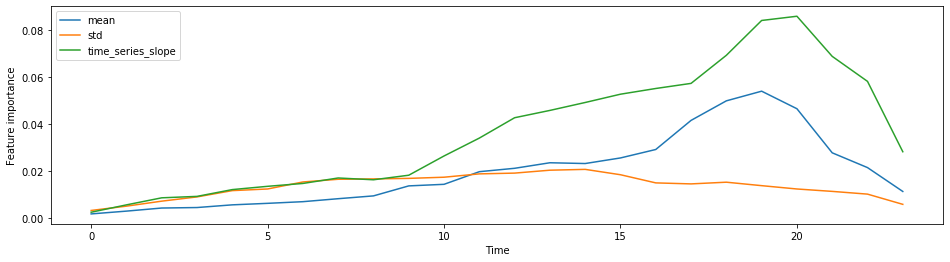

In [14]:
fi = tsf.feature_importances_
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25))
fi.plot(ax=ax)
ax.set(xlabel="Time", ylabel="Feature importance");

#### Aside: our dependencies
* scikit-learn & scipy for fundamental ML/stats tools;
* numpy and pandas (and possibly [awkward-array](https://awkward-array.org/quickstart.html)) for data handling & manipulations;
* numba, Cython & joblib for more efficient computations;
* many specific time series analysis libraries such as statsmodels, [pmdarima](https://github.com/alkaline-ml/pmdarima), [tsfresh](https://tsfresh.readthedocs.io) ...

Check out our [list of related software](https://github.com/alan-turing-institute/sktime/wiki/related-software).

## Forecasting

1. **Generative setting.** Single instances of (univariate or multivariate) time series
2. **Learning.** Learn association between adjacent values (across variables if we have exogenous variables) that is generalizable to future data 
3. **Evaluation.** Estimate and compare generalization error on unseen (future) test data 

<img src="../images/forecasting.png" width=750 />

In [15]:
import pandas as pd
from sktime.datasets import load_airline
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import smape_loss
from sktime.utils.plotting.forecasting import plot_ys

%matplotlib inline

We will use the famous Box-Jenkins airline data set, which shows the number of international airline passengers per month from 1949-1960.

Note that since we're working with monthly data, the seasonal periodicity (sp), or the number of periods per year, is 12.

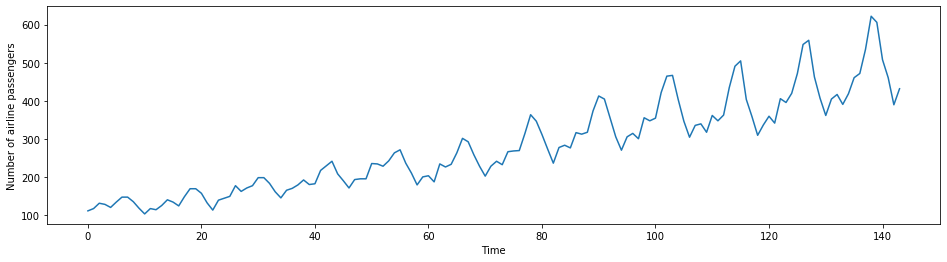

In [16]:
y = load_airline()
fig, ax = plot_ys(y)
ax.set(xlabel="Time", ylabel="Number of airline passengers");

### Specifying the forecasting task

Next we will define a forecasting task.

* We will try to predict the last 3 years of data, using the previous years as training data. Each point in the series represents a month, so we should hold out the last 36 points as test data, and use 36-step ahead forecasting horizon to evaluate forecasting performance.
* We will use the sMAPE (symmetric mean absolute percentage error) to quantify the accuracy of our forecasts. A lower sMAPE means higher accuracy.

We can split the data as follows:

108 36


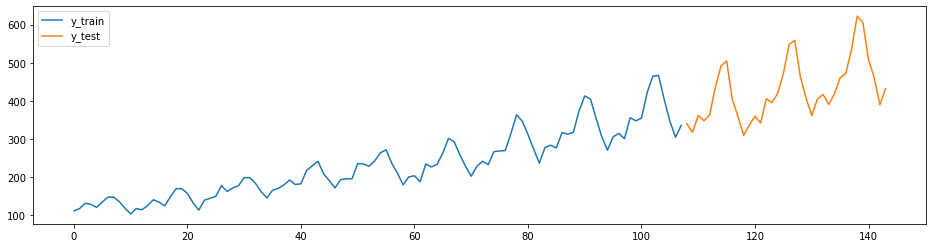

In [17]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

When we want to generate forecasts, we need to specify the forecasting horizon and pass that to our forecasting algorithm. We can specify the forecasting horizon as a numpy array of the steps ahead relative to the end of the training series:

In [18]:
fh = np.arange(1, len(y_test) + 1)  # we add 1 because the `stop` value is exclusive in `np.arange`
fh

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36])

So here we're interested in predicting from the first to to the 36th step ahead. 

Of course you could you use other forecasting horizons. For example, to predict only the second and fifth step ahead, you could write:

```python
fh = np.array([2, 5])  # 2nd and 5th step ahead
```

### Baseline

0.23195770387951434

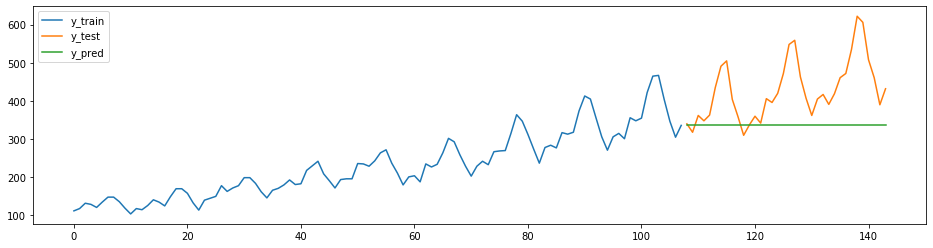

In [19]:
# using sktime 
from sktime.forecasting.naive import NaiveForecaster

forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_pred, y_test)

0.145427686270316

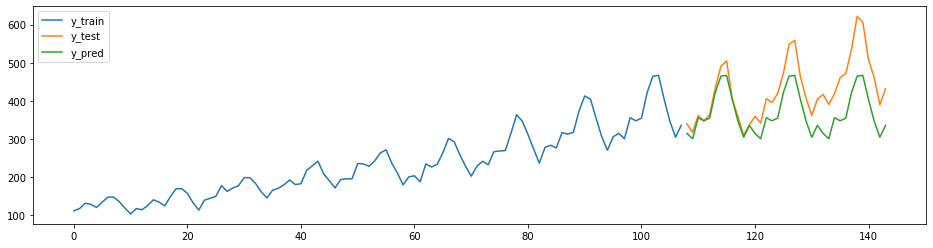

In [20]:
forecaster = NaiveForecaster(strategy="seasonal_last", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

### Can I not use scikit-learn?

In principle, yes, but many pitfalls ...

#### Pitfall 1: model validation

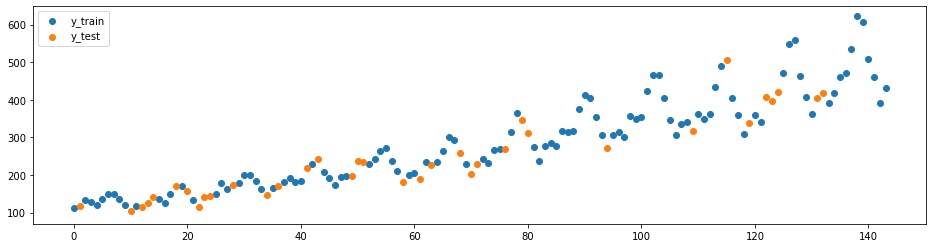

In [21]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y)
plot_ys(y_train.sort_index(), y_test.sort_index(), labels=["y_train", "y_test"]);

This leads to leakage: 

> The data you are using to train a machine learning algorithm happens to have the information you are trying to predict.

But `train_test_split(y, shuffle=False)` works, which is what `temporal_train_test_split(y)` does in sktime:

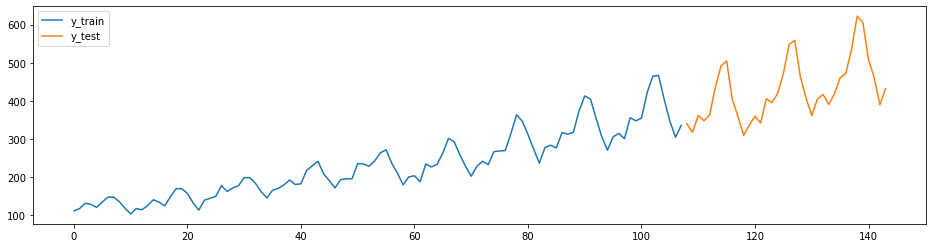

In [22]:
y_train, y_test = temporal_train_test_split(y, test_size=36)
plot_ys(y_train, y_test, labels=["y_train", "y_test"]);

### Pitfall 2: how to apply regression algorithms?

In order to use scikit-learn, we have to first transform the data into the required tabular format, then fit a regressor and finally generate forecasts. 

#### Reduction: from forecasting to regression
Forecasting is often solved via regression. This approach is sometimes called reduction, because we reduce the forecasting task to the simpler but related task of tabular regression. This allows to apply any regression algorithm to the forecasting problem.

Reduction to regression works as follows: We first need to transform the data into the required tabular format. We can do this by cutting the training series into windows of a fixed length and stacking them on top of each other. Our target variable consists of the subsequent observation for each window.

We could write some code to do that, as for example in the [M4 competition](https://github.com/Mcompetitions/M4-methods):

In [23]:
# slightly modified code from the M4 competition
def split_into_train_test(data, in_num, fh):
    """
    Splits the series into train and test sets. Each step takes multiple points as inputs
    :param data: an individual TS
    :param fh: number of out of sample points
    :param in_num: number of input points for the forecast
    :return:
    """
    train, test = data[:-fh], data[-(fh + in_num):]
    x_train, y_train = train[:-1], np.roll(train, -in_num)[:-in_num]
    x_test, y_test = test[:-1], np.roll(test, -in_num)[:-in_num]
#     x_test, y_test = train[-in_num:], np.roll(test, -in_num)[:-in_num]

    # reshape input to be [samples, time steps, features] (N-NF samples, 1 time step, 1 feature)
    x_train = np.reshape(x_train, (-1, 1))
    x_test = np.reshape(x_test, (-1, 1))
    temp_test = np.roll(x_test, -1)
    temp_train = np.roll(x_train, -1)
    for x in range(1, in_num):
        x_train = np.concatenate((x_train[:-1], temp_train[:-1]), 1)
        x_test = np.concatenate((x_test[:-1], temp_test[:-1]), 1)
        temp_test = np.roll(temp_test, -1)[:-1]
        temp_train = np.roll(temp_train, -1)[:-1]

    return x_train, y_train, x_test, y_test

In [24]:
# here we split the time index, rather than the actual values, to show how we split the windows
feature_window, target_window, _, _ = split_into_train_test(y.index.values, 10, len(fh))

feature_window[:5, :]

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10],
       [ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11],
       [ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12],
       [ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13]])

In [25]:
target_window[:5]

array([10, 11, 12, 13, 14])

In [26]:
# now we can split the actual values of the time series
x_train, y_train, x_test, y_test = split_into_train_test(y.values, 10, len(fh))
print(x_train.shape, y_train.shape)

(98, 10) (98,)


In [27]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

> This requires a lot of hand-written code which is often error-prone, not modular and not tuneable. 

> Note also that these steps involve a number of implicit hyper-parameters:
* the way you slice the time series into windows (e.g. the window length)
* the way you generate forecasts (recursive strategy, direct strategy, other hybrid strategies)

### Pitfall 3: how to generate forecasts?

In [28]:
print(x_test.shape, y_test.shape)

# add back time index to y_test 
y_test = pd.Series(y_test, index=y.index[-len(fh):])

(36, 10) (36,)


In [29]:
y_pred = model.predict(x_test)
smape_loss(pd.Series(y_pred, index=y_test.index), y_test)

0.11614293555618407

But what's the problem here?

> We actually don't make a multi-step-ahead forecast up to the 36th step ahead. Instead, we make 36 single-step-ahead forecasts always using the most recent data. But that's a solution to a different learning task! 

To fix this problem, we could write some code to do this recursively as in the M4 competition:

In [30]:
# modified code from the M4 competition
predictions = []
last_window = x_train[-1, :].reshape(1, -1)  # make it into 2d array

last_prediction = model.predict(last_window)[0]  # take value from array

for i in range(len(fh)):
    # append prediction
    predictions.append(last_prediction)
    
    # update last window using previously predicted value
    last_window[0] = np.roll(last_window[0], -1)
    last_window[0, (len(last_window[0]) - 1)] = last_prediction
    
    # predict next step ahead
    last_prediction = model.predict(last_window)[0]

y_pred_rec = pd.Series(predictions, index=y_test.index)
smape_loss(y_pred_rec, y_test)

0.2241373304361024

### Reduction: from forecasting to regression

sktime provides a meta-estimator for this approach, which is: 

* **modular** and **compatible with scikit-learn**, so that we can easily apply any scikit-learn regressor to solve our forecasting problem,
* **tuneable**, allowing us to tune hyper-parameters like the window length or strategy to generate forecasts
* **adaptive**, in the sense that it adapts the scikit-learn's estimator interface to that of a forecaster, making sure that we can tune and properly evaluate our model

<img src="images/forecasting-to-regression-reduction.png" />

In [31]:
y = load_airline()
y_train, y_test = temporal_train_test_split(y, test_size=36)
print(y_train.shape[0], y_test.shape[0])

108 36


0.14008272913734346

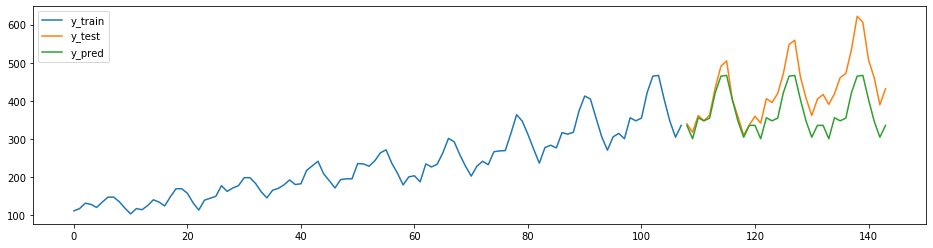

In [32]:
from sktime.forecasting.compose import ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor

regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = ReducedRegressionForecaster(regressor=regressor, window_length=12, strategy="recursive")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

### Building compositite models

0.04038731595566064

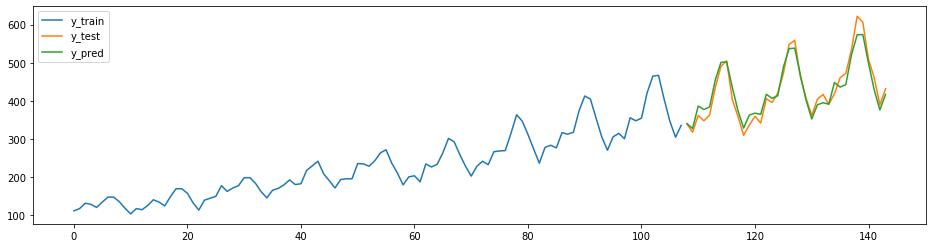

In [33]:
from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.transformers.single_series.detrend import Deseasonalizer
from sktime.transformers.single_series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster

forecaster = TransformedTargetForecaster([
    ("deseasonalise", Deseasonalizer(model="multiplicative", sp=12)),
    ("detrend", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("forecast", ReducedRegressionForecaster(regressor=regressor, window_length=15, strategy="recursive"))
])
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

Of course, we could try again to optimise the hyper-parameters of components of the pipeline.

### Statistical forecasters

0.05106126665215278

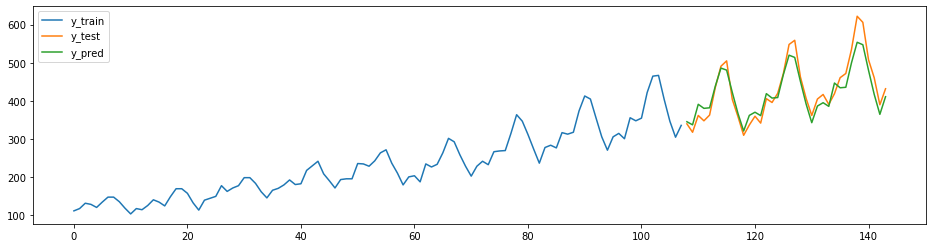

In [34]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

# Recall that since we're working with monthly data, the
# seasonal periodicity (sp), or the number of periods 
# per year, is 12.

forecaster = ExponentialSmoothing(trend="add", seasonal="multiplicative", sp=12)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

## More complications

* Time-heterogenous data: essentially, time index is not shared across instances/variables (for example, unequal-length series or timestamped data)
* Data representation

## Recap

* various distict but related time series learning tasks
* reduction allows to use algorithms for one task to solve another one
* rich time series specific methodologies and ecosystem, but many packages are not easily interoperable

## How to contribute

All kinds of contributions are welcome! 

* Documentation (user guide, API reference)
* Mentoring
* Field testing, API design & user feedback
* Algorithms (forecasting, time series classification/regression)
* Framework development (clustering, time series annotation)
* Data representation

How to get in touch: 
* Gitter: https://gitter.im/sktime/community
* discord: https://discord.com/invite/gqSab2K 
* GitHub: https://github.com/sktime, https://github.com/alan-turing-institute/sktime
* Email: markus.loning@gmail.com


![](images/contributors.png)

## Thank you for listening!
Any questions?